In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import re
import numpy as np

#  Cohort Analysis: Exploring Consumer Behavior Over Time 

**What is  cohort analysis?**

Cohort is a group of people who share similar characteristics.  
Cohort analysis is a type of behavioral analytics in which we group our users based on their common characteristics within a defined time-span to better track and understand their actions. In cohort analysis, we compare the behavior of customers or users over a period of time. Data can be obtained from a variety of sources such as ecommerce, product websites, mobile apps, business sales databases. We can then turn raw data into a valuable visualization that shows the current state of the business, product, or specific feature.


The first step in conducting cohort analysis is to select a key indicator, a metric that will become the main tool of our research. Based on the purpose of the cohort analysis, we can use the retention rate, churn rate, product sales number, transactions, app install number, etc.     


Cohort analysis is a simple tool for identifying the most important and hidden problems in a product or business. For example, the number of users of a certain product never changes, and we take this information as a very good indicator of the state of the business. However, cohort analysis shows that every day there are a huge number of new users who sign up, start using the product within an hour, and then they churn. We now look at the same information from a different perspective and understand that we may need to improve user experience, product quality, market targeting, and more. 

As a result of cohort analysis, we measure how many users stayed (engagement) instead of how many users came (growth) in a given time span.
In short, cohort analysis helps us separate growth metrics from engagement metrics. 

<br>

**Types of cohort analysis**
<br><br>
There are two types of cohort analysis. We'll dive deeper into each of them while coding.
<br>
1. Acquisition cohorts: Groups divided based on when they signed up for your product
2. Behavioral cohorts: Groups divided based on their behaviors and actions in your product

![alt text](docs/cohort.png "Cohort Image")

Image from: https://clevertap.com/blog/cohort-analysis/

There are two ways to read cohort table:
1. User lifetime perspective (vertically to)
2. Product lifetime perspective (horizontally to right)  


![](coh.png)

### Data

For cohort analysis, we will use the cleaned data from the previous lesson.

In [2]:
data = pd.read_csv('data_cleaned.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,OrderHour,OrderMonth,OrderWeekday
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,8,12,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,12,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,8,12,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,12,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,12,2


First, we need to transform our data for cohort analysis. For this, we are going to create an order level dataset, that is, each row will represent single order.
For the analysis, we must have two variables: customer ids and invoice dates. 
For behavioral analysis, we can add the total price, the number of items customer has bought, and the total number of items. 

In [3]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['PurchaseMonth'] = data['InvoiceDate'].dt.to_period("M")

In [4]:
grouped = data.groupby(['CustomerID', 'PurchaseMonth'], as_index=False).agg({'InvoiceNo' : 'count', 
                                                                             'Quantity' : 'sum', 
                                                                             'TotalPrice' : 'sum'})
grouped['CustomerID'] = grouped['CustomerID'].astype('O')
grouped.head()

,CustomerID,PurchaseMonth,InvoiceNo,Quantity,TotalPrice
0,12347,2010-12,31,319,711.79
1,12347,2011-01,29,315,475.39
2,12347,2011-04,24,483,636.25
3,12347,2011-06,18,196,382.52
4,12347,2011-08,22,277,584.91


In [5]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13027 entries, 0 to 13026
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   CustomerID     13027 non-null  object   
 1   PurchaseMonth  13027 non-null  period[M]
 2   InvoiceNo      13027 non-null  int64    
 3   Quantity       13027 non-null  int64    
 4   TotalPrice     13027 non-null  float64  
dtypes: float64(1), int64(2), object(1), period[M](1)
memory usage: 610.6+ KB


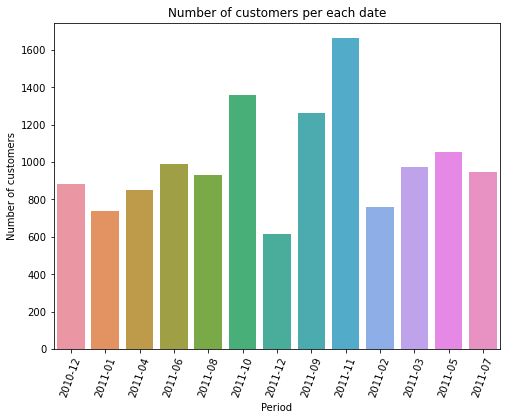

In [6]:
# New dataset description
plt.figure(figsize=(8, 6))
ax = sns.countplot(x= grouped['PurchaseMonth'])
ax.set(title='Number of customers per each date',
       xlabel='Period', 
       ylabel='Number of customers');
var = plt.xticks(rotation = 70)

In [7]:
grouped['FirstPurchaseMonth'] = grouped.groupby('CustomerID')['PurchaseMonth'].transform('min')
grouped.head()

,CustomerID,PurchaseMonth,InvoiceNo,Quantity,TotalPrice,FirstPurchaseMonth
0,12347,2010-12,31,319,711.79,2010-12
1,12347,2011-01,29,315,475.39,2010-12
2,12347,2011-04,24,483,636.25,2010-12
3,12347,2011-06,18,196,382.52,2010-12
4,12347,2011-08,22,277,584.91,2010-12


The main problem with our dataset is that we have no historical data. This means, we have to consider the user's first purchase date  as the date he first came to us. In other words, the first purchase we see in this dataset may not be the actual first purchase of a given customer. However, it is impossible to verify this without access to the entire set of historical data of the retailer.

We then aggregate the data for the month of purchase and the month of the first purchase and count the number of unique customers in each group. In addition, we add Period Number that indicates the number of periods between the month of the cohort and the month of purchase.

In [8]:
cohorts = grouped.groupby(['PurchaseMonth', 'FirstPurchaseMonth'], as_index=False).agg({"CustomerID" : 'count'})
cohorts['PeriodNumber'] = (cohorts['PurchaseMonth'] - cohorts['FirstPurchaseMonth']).apply(lambda i: i.n)
cohorts = cohorts.rename(mapper={'CustomerID': 'CustomersNumber'}, axis='columns')
cohorts.head()

,PurchaseMonth,FirstPurchaseMonth,CustomersNumber,PeriodNumber
0,2010-12,2010-12,885,0
1,2011-01,2010-12,323,1
2,2011-01,2011-01,415,0
3,2011-02,2010-12,286,2
4,2011-02,2011-01,91,1


Next, we create pivot table in a way that each row contains information about a given cohort and each column contains values for a certain period.

In [9]:
cohort_pivot = cohorts.pivot_table(index = 'FirstPurchaseMonth',
                                  columns = 'PeriodNumber',
                                  values = 'CustomersNumber')

cohort_pivot

PeriodNumber,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstPurchaseMonth,,,,,,,,,,,,,
2010-12,885.0,323.0,286.0,339.0,320.0,352.0,320.0,308.0,312.0,350.0,330.0,444.0,235.0
2011-01,415.0,91.0,111.0,95.0,133.0,120.0,103.0,100.0,124.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,109.0,103.0,93.0,97.0,104.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,67.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,63.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,80.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,187.0,33.0,38.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,34.0,41.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To get the retention matrix, we need to divide each row's values by the first row's value, which is actually the size of the cohort — all customers who made their first purchase on a given month.

In [10]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

PeriodNumber,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstPurchaseMonth,,,,,,,,,,,,,
2010-12,1.0,0.364972,0.323164,0.383051,0.361582,0.397740,0.361582,0.348023,0.352542,0.395480,0.372881,0.501695,0.265537
2011-01,1.0,0.219277,0.267470,0.228916,0.320482,0.289157,0.248193,0.240964,0.298795,0.327711,0.366265,0.118072,NaN
2011-02,1.0,0.186842,0.186842,0.286842,0.271053,0.244737,0.255263,0.273684,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.148230,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.210000,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.091549,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.330579,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.176471,0.203209,0.224599,0.272727,0.112299,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.201183,0.242604,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we're going to visualize the pivot tables to better understand the current state of customer retention.

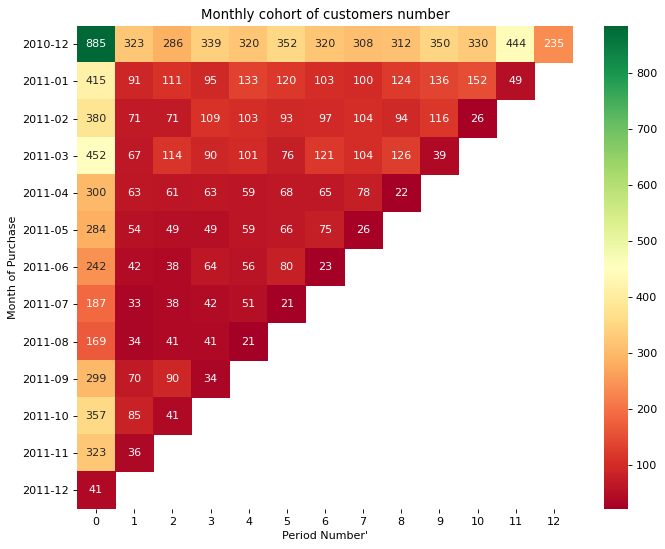

In [11]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(cohort_pivot, mask=cohort_pivot.isnull(), annot=True, cmap='RdYlGn' , fmt='g' )
plt.title('Monthly cohort of customers number')
plt.xlabel("Period Number'")
var = plt.ylabel("Month of Purchase")


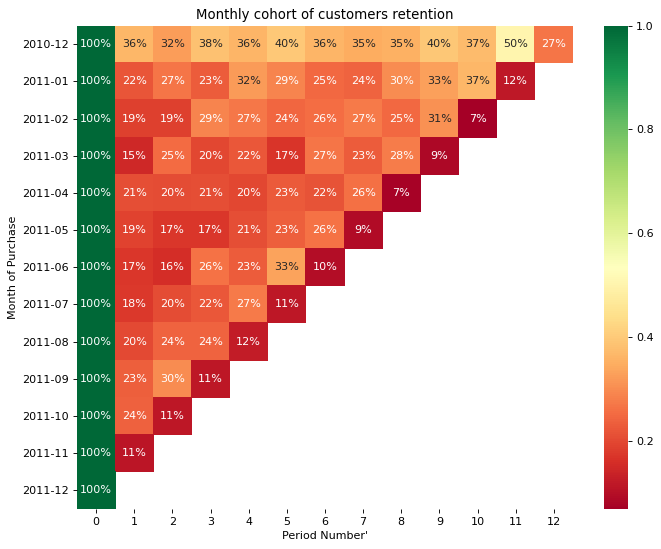

In [12]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(retention_matrix, mask=cohort_pivot.isnull(), annot=True, cmap='RdYlGn' , fmt='.0%' )
plt.title('Monthly cohort of customers retention')
plt.xlabel("Period Number'")
var = plt.ylabel("Month of Purchase")

Great job! For further analysis, we can use other variables to understand customer retention behavior. For example, the average expenses of a given cohort or the number of products purchased for a specific month. Let's look at one of them.

In [13]:
cohorts_behavior = grouped.groupby(['PurchaseMonth', 'FirstPurchaseMonth'], as_index=False).agg({"TotalPrice" : 'mean'})
cohorts_behavior['PeriodNumber'] = (cohorts['PurchaseMonth'] - cohorts['FirstPurchaseMonth']).apply(lambda i: i.n)
cohorts_behavior = cohorts_behavior.rename(mapper={'TotalPrice': 'AverageSpendings'}, axis='columns')
cohorts_behavior.head()

,PurchaseMonth,FirstPurchaseMonth,AverageSpendings,PeriodNumber
0,2010-12,2010-12,641.870870,0
1,2011-01,2010-12,849.389598,1
2,2011-01,2011-01,512.542651,0
3,2011-02,2010-12,813.006224,2
4,2011-02,2011-01,585.546264,1


In [14]:
cohort_pivot2 = cohorts_behavior.pivot_table(index = 'FirstPurchaseMonth',
                                  columns = 'PeriodNumber',
                                  values = 'AverageSpendings')

cohort_size = cohort_pivot2.iloc[:,0]
spending_percentage = cohort_pivot2.divide(cohort_size, axis = 0)
spending_percentage

PeriodNumber,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstPurchaseMonth,,,,,,,,,,,,,
2010-12,1.0,1.323303,1.266620,1.367930,0.986744,1.445602,1.518314,1.559699,1.635268,2.096860,2.124303,1.786758,1.22343
2011-01,1.0,1.142434,1.099855,1.334002,1.174520,1.354828,1.318051,1.395834,1.125884,1.504429,1.569408,1.043410,NaN
2011-02,1.0,0.938797,1.325141,1.063109,0.934949,0.878466,1.231916,1.403886,1.413274,1.334888,0.977150,NaN,NaN
2011-03,1.0,0.982273,1.175626,1.080040,1.145293,1.200364,1.223179,1.514622,1.288009,0.755633,NaN,NaN,NaN
2011-04,1.0,1.134431,1.014183,0.955618,1.105761,1.083089,1.088641,1.085501,0.695558,NaN,NaN,NaN,NaN
2011-05,1.0,0.819276,0.974458,0.926062,1.120824,1.173353,1.050527,0.971603,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.863615,0.902198,1.212399,1.202130,1.292451,0.907700,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.900576,1.019769,1.065561,0.959235,0.711850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,1.211391,1.662246,2.043265,1.391470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


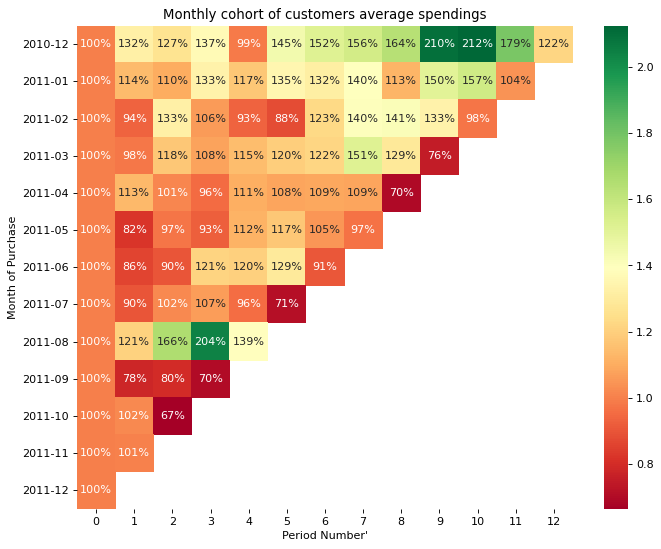

In [15]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(spending_percentage, mask=cohort_pivot.isnull(), annot=True, cmap='RdYlGn' , fmt='.0%' )
plt.title('Monthly cohort of customers average spendings')
plt.xlabel("Period Number'")
var = plt.ylabel("Month of Purchase")